# Room Occupancy Estimation:

The dataset collected from Kaggle: https://www.kaggle.com/datasets/ananthr1/room-occupancy-estimation-data-set.
The setup of the room consisted of 7 senor nodes and one edge node in star configuration with sensor nodes transmitting data to edge every 30s using wireless transceivers.

The model shall predict the Room occupancy which will help in installation or even cooling load for an HVAC system. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Importing dataset

In [2]:
dataset = pd.read_csv('Occupancy_Estimation.csv')

dataset.head()

,Date,Time,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,S5_CO2,S5_CO2_Slope,S6_PIR,S7_PIR,Room_Occupancy_Count
0,2017/12/22,10:49:41,24.94,24.75,24.56,25.38,121,34,53,40,0.08,0.19,0.06,0.06,390,0.769231,0,0,1
1,2017/12/22,10:50:12,24.94,24.75,24.56,25.44,121,33,53,40,0.93,0.05,0.06,0.06,390,0.646154,0,0,1
2,2017/12/22,10:50:42,25.00,24.75,24.50,25.44,121,34,53,40,0.43,0.11,0.08,0.06,390,0.519231,0,0,1
3,2017/12/22,10:51:13,25.00,24.75,24.56,25.44,121,34,53,40,0.41,0.10,0.10,0.09,390,0.388462,0,0,1
4,2017/12/22,10:51:44,25.00,24.75,24.56,25.44,121,34,54,40,0.18,0.06,0.06,0.06,390,0.253846,0,0,1


The S1,S2,S3 and S4 are the sensors numbers.
Attribute Information:

Date: YYYY/MM/DD

Time: HH:MM:SS

Temperature: In degree Celsius

Light: In Lux

Sound: In Volts (amplifier output read by ADC)

CO2: In PPM

CO2 Slope: Slope of CO2 values taken in a sliding window

PIR: Binary value conveying motion detection

Room_Occupancy_Count: Ground Truth

# EDA

In [3]:
dataset.shape

(10129, 19)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10129 entries, 0 to 10128
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  10129 non-null  object 
 1   Time                  10129 non-null  object 
 2   S1_Temp               10129 non-null  float64
 3   S2_Temp               10129 non-null  float64
 4   S3_Temp               10129 non-null  float64
 5   S4_Temp               10129 non-null  float64
 6   S1_Light              10129 non-null  int64  
 7   S2_Light              10129 non-null  int64  
 8   S3_Light              10129 non-null  int64  
 9   S4_Light              10129 non-null  int64  
 10  S1_Sound              10129 non-null  float64
 11  S2_Sound              10129 non-null  float64
 12  S3_Sound              10129 non-null  float64
 13  S4_Sound              10129 non-null  float64
 14  S5_CO2                10129 non-null  int64  
 15  S5_CO2_Slope       

In [5]:
dataset.columns

Index(['Date', 'Time', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR',
       'Room_Occupancy_Count'],
      dtype='object')

### Dropping the irrelevant columns .

In [6]:
cols_to_drop = ['Date','Time']

dataset.drop(cols_to_drop,axis=1,inplace=True)

<AxesSubplot:>

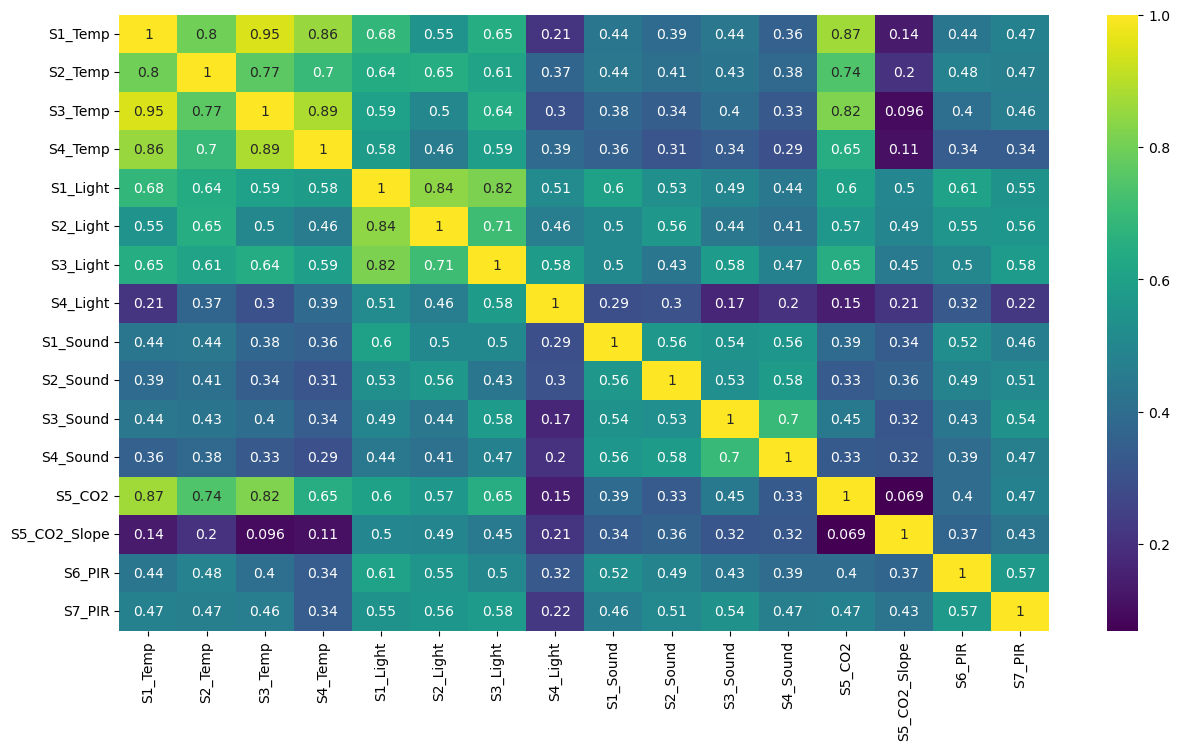

In [7]:
plt.subplots(figsize=(15,8))

corr = dataset.drop('Room_Occupancy_Count',axis=1).corr()

sns.heatmap(corr,annot=True,cmap='viridis')

## Finding columns with  correlation greater than specified threshold:

In [8]:
def correlation(data,threshold):
    columns_corr = set() #taking set to avoid repeated values
    corr_matrix = data.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i,j] > threshold:
                colname = corr_matrix.columns[i]
                columns_corr.add(colname)
    return columns_corr

In [9]:
correlation(dataset.drop('Room_Occupancy_Count',axis=1),0.8)

{'S2_Light', 'S3_Light', 'S3_Temp', 'S4_Temp', 'S5_CO2'}

### WIth domain knowledge of HVAC,S5_CO2 feature should be retained. Other features can be dropped.

In [10]:
cols_to_drop = ['S2_Light', 'S3_Light', 'S3_Temp', 'S4_Temp']

dataset.drop(cols_to_drop,axis=1,inplace=True)

### Sound,CO2_slope and PIR (motion detection) can be dropped as well.

In [11]:
dataset.drop(['S1_Sound', 'S2_Sound','S3_Sound', 'S4_Sound','S5_CO2_Slope','S6_PIR','S7_PIR'],axis=1,inplace=True)

In [12]:
dataset.columns

Index(['S1_Temp', 'S2_Temp', 'S1_Light', 'S4_Light', 'S5_CO2',
       'Room_Occupancy_Count'],
      dtype='object')

In [13]:
dataset.isnull().sum()

S1_Temp                 0
S2_Temp                 0
S1_Light                0
S4_Light                0
S5_CO2                  0
Room_Occupancy_Count    0
dtype: int64

## No Null values.

In [14]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
S1_Temp,10129.0,25.454012,0.351351,24.94,25.19,25.38,25.63,26.38
S2_Temp,10129.0,25.546059,0.586325,24.75,25.19,25.38,25.63,29.00
S1_Light,10129.0,25.445059,51.011264,0.00,0.00,0.00,12.00,165.00
S4_Light,10129.0,13.220259,19.602219,0.00,0.00,0.00,22.00,74.00
S5_CO2,10129.0,460.860401,199.964940,345.00,355.00,360.00,465.00,1270.00
Room_Occupancy_Count,10129.0,0.398559,0.893633,0.00,0.00,0.00,0.00,3.00


## Insights:

The Temperature range is from 24C to 29C.

The Light range is 0 lux to 280 lux .

The sound range is 0 to 3.6 Volts. 

The CO2 range is 355 PPM to 1270 PPM.

These values shall be scaled before training.

## Analysing relation of Temp, Light, Sound and CO2 with Number of Occupants:

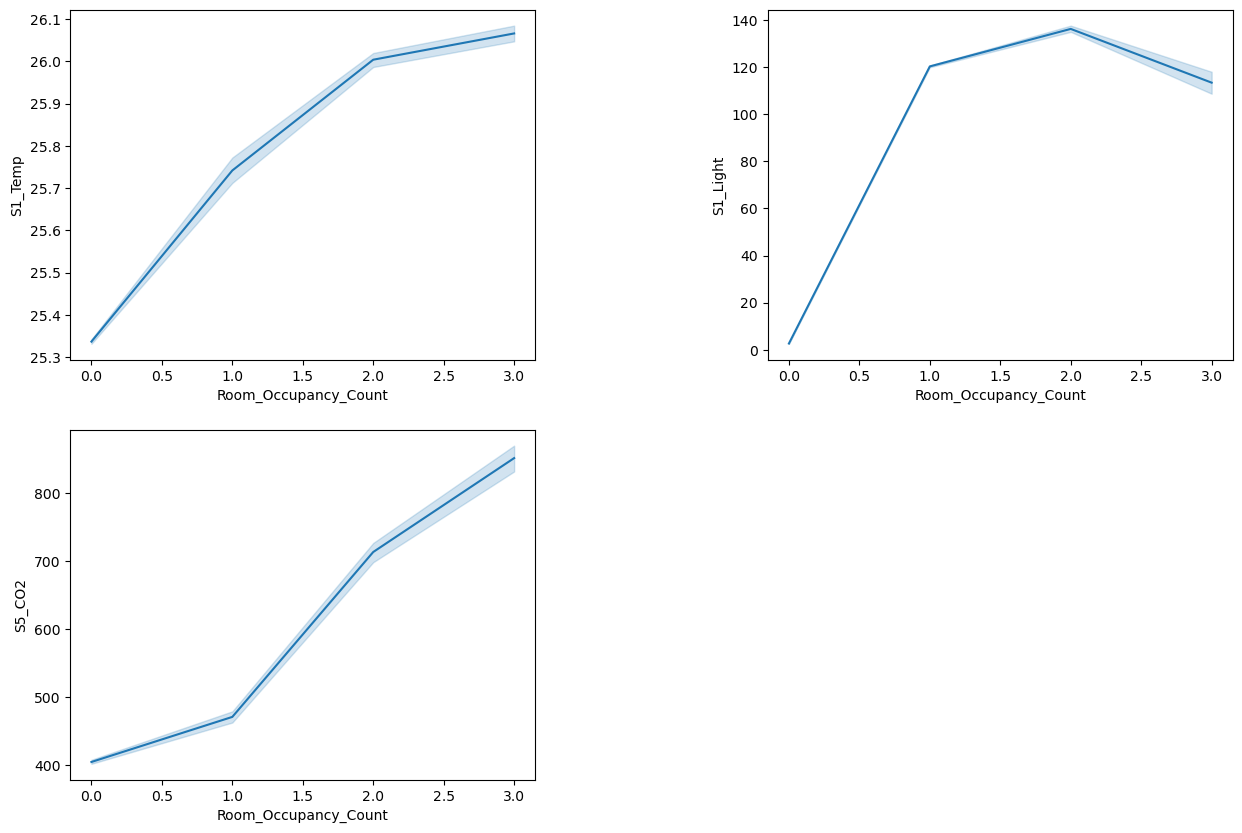

In [15]:
variables = ['S1_Temp','S1_Light','S5_CO2']

plt.figure(figsize=(15,10))
plt.subplots_adjust(wspace=0.5)
for i in range(0,len(variables)):
    plt.subplot(2,2,i+1)
    sns.lineplot(x=dataset['Room_Occupancy_Count'],y=dataset[variables[i]])

### Check for outliers

In [16]:
dataset.columns

Index(['S1_Temp', 'S2_Temp', 'S1_Light', 'S4_Light', 'S5_CO2',
       'Room_Occupancy_Count'],
      dtype='object')

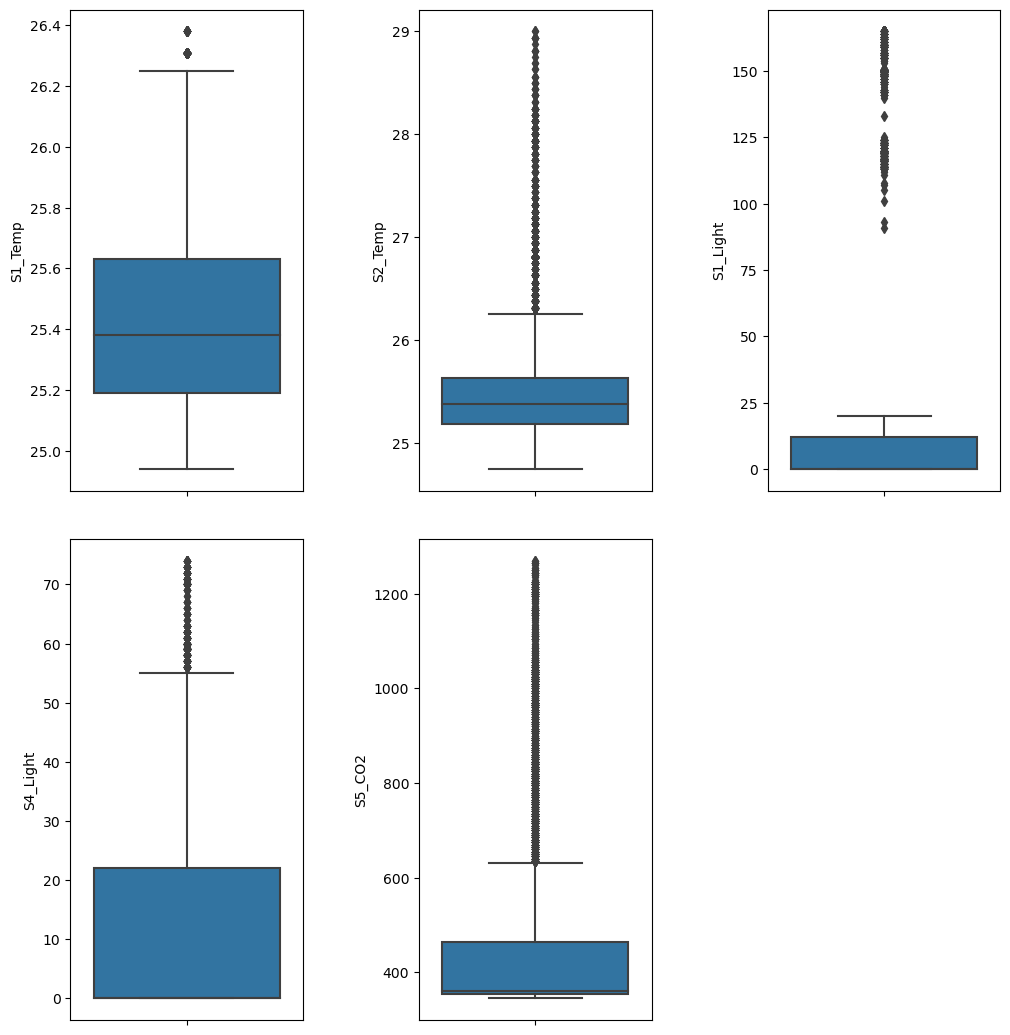

In [17]:
cols = ['S1_Temp', 'S2_Temp', 'S1_Light', 'S4_Light', 'S5_CO2']

plt.figure(figsize=(12,20))
plt.subplots_adjust(hspace=0.1,wspace=0.5)
for i in range(0,len(cols)):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=dataset[cols[i]])


### Outliers shall be replaced by respective means

### Writing a function to detect outlier using IQR 

In [18]:
outlier = []

def outlier_iqr(data): #making a function to detect outlier using IQR 
    
#     q1 = np.percentile(data,25)
#     q3 = np.percentile(data,75)
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3-q1
    lower_fence = q1-(1.5*iqr)
    higher_fence = q3+(1.5*iqr)
    
    for index,row in data.items():
        if row < lower_fence or row > higher_fence:
            outlier.append(row)
    return outlier

In [19]:
cols

['S1_Temp', 'S2_Temp', 'S1_Light', 'S4_Light', 'S5_CO2']

In [20]:
for col in cols:
    outlier_iqr(dataset[col])
    col_mean = dataset[col].mean()
    for i in outlier:
         dataset[col] = dataset[col].replace(i,col_mean)

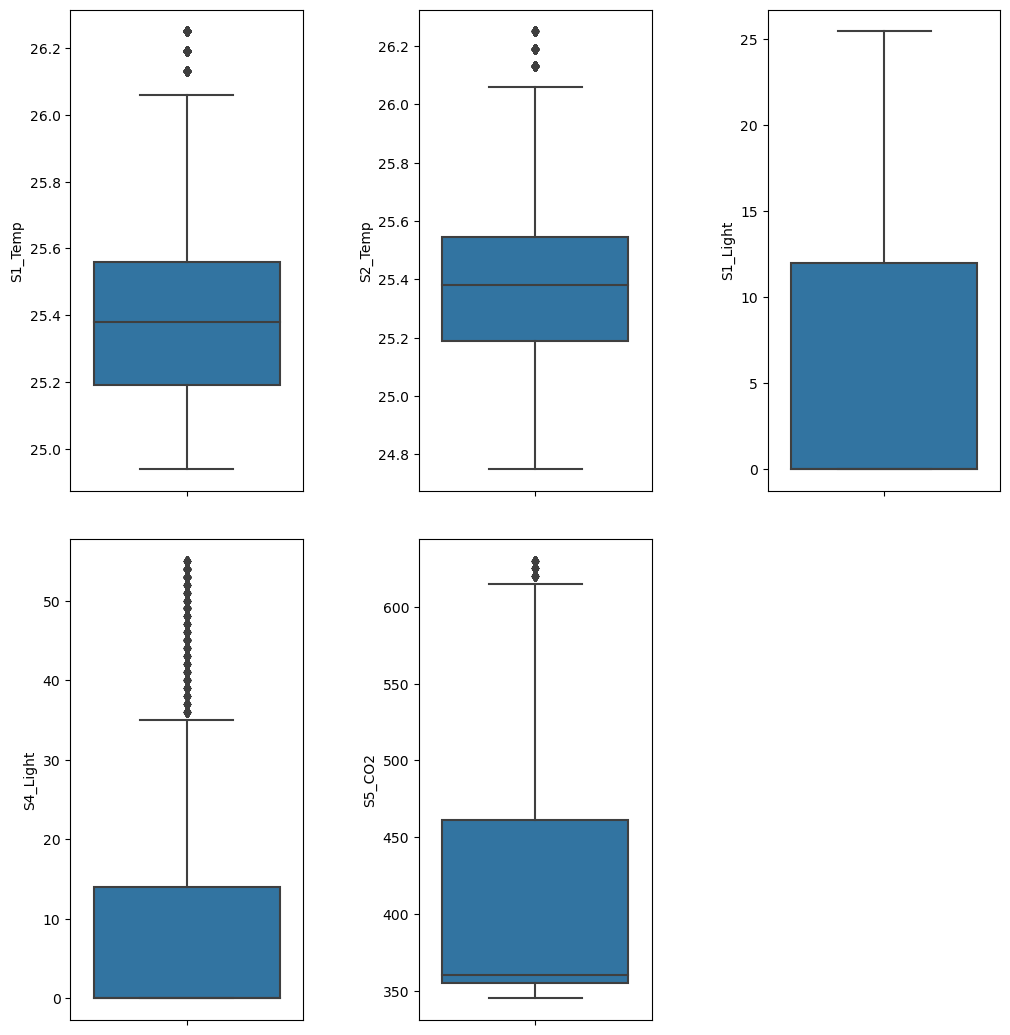

In [21]:
cols = ['S1_Temp', 'S2_Temp', 'S1_Light', 'S4_Light', 'S5_CO2']

plt.figure(figsize=(12,20))
plt.subplots_adjust(hspace=0.1,wspace=0.5)
for i in range(0,len(cols)):
    plt.subplot(3,3,i+1)
    sns.boxplot(y=dataset[cols[i]])

## Target Value Counts:

In [22]:
dataset['Room_Occupancy_Count'].value_counts()

0    8228
2     748
3     694
1     459
Name: Room_Occupancy_Count, dtype: int64

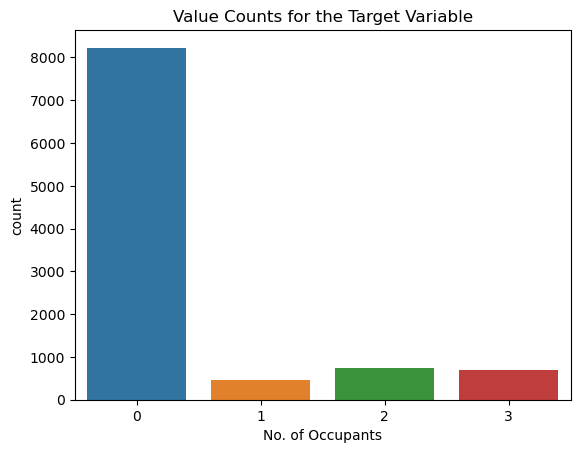

In [23]:
sns.countplot(dataset['Room_Occupancy_Count'])

plt.title('Value Counts for the Target Variable')
plt.xlabel('No. of Occupants')
plt.show()

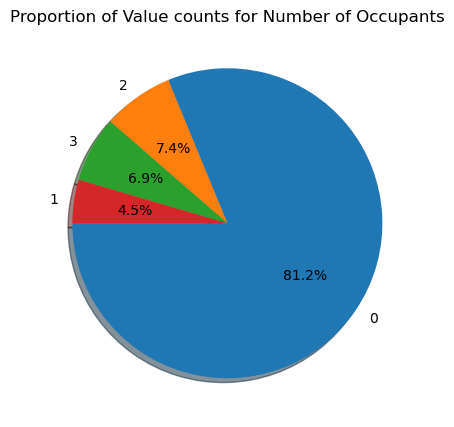

In [24]:
occupants = dict(dataset['Room_Occupancy_Count'].value_counts())
labels = []
value = []

for keys, values in occupants.items():
    labels.append(keys)
    value.append(values)

plt.subplots(figsize=(5,6))

plt.pie(x=value,labels=labels,autopct='%1.1f%%',shadow=True,startangle=180)

plt.title('Proportion of Value counts for Number of Occupants')
plt.show()

In [25]:
value_count_percent = round(100* dataset['Room_Occupancy_Count'].value_counts() / len(dataset['Room_Occupancy_Count']),3)

print(value_count_percent)

0    81.232
2     7.385
3     6.852
1     4.532
Name: Room_Occupancy_Count, dtype: float64


### The dataset is highly imbalanced. This will be handled by using SMOTE on training set.

## Data Prepration for train-test split

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

In [27]:
X = dataset.drop('Room_Occupancy_Count',axis=1)
y = dataset['Room_Occupancy_Count']

In [28]:
X.head()

,S1_Temp,S2_Temp,S1_Light,S4_Light,S5_CO2
0,24.94,24.75,25.445059,40.0,390.0
1,24.94,24.75,25.445059,40.0,390.0
2,25.00,24.75,25.445059,40.0,390.0
3,25.00,24.75,25.445059,40.0,390.0
4,25.00,24.75,25.445059,40.0,390.0


In [29]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')

Shape of X_train: (7596, 5)
Shape of X_test: (2533, 5)


In [30]:
print(y_train.value_counts())

print(y_test.value_counts())

0    6168
2     553
3     524
1     351
Name: Room_Occupancy_Count, dtype: int64
0    2060
2     195
3     170
1     108
Name: Room_Occupancy_Count, dtype: int64


<AxesSubplot:xlabel='Room_Occupancy_Count', ylabel='count'>

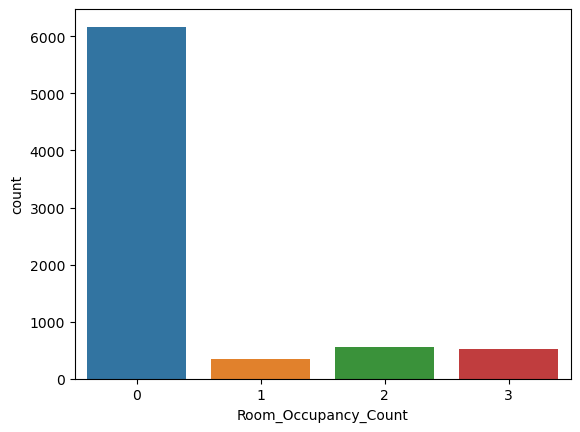

In [31]:
sns.countplot(y_train,)

### Normalising the data:

In [32]:
norm = MinMaxScaler()
X_train_norm = norm.fit_transform(X_train)
X_test_norm = norm.transform(X_test)

### Using Smote to oversample

In [33]:
smote = SMOTE()

In [34]:
X_train_smt,y_train_smt = smote.fit_resample(X_train_norm,y_train)

In [35]:
print(f'Shape of X_train_smt: {X_train_smt.shape}')
print(f'Shape of y_train_smt: {y_train_smt.shape}')
print(f'\nValueCounts: \n{y_train_smt.value_counts()}')

Shape of X_train_smt: (24672, 5)
Shape of y_train_smt: (24672,)

ValueCounts: 
0    6168
3    6168
1    6168
2    6168
Name: Room_Occupancy_Count, dtype: int64


## Model Building

In [36]:
from sklearn.tree import DecisionTreeClassifier

In [37]:
dt_clf = DecisionTreeClassifier()


In [38]:
dt_clf.fit(X_train_smt,y_train_smt)

DecisionTreeClassifier()

In [39]:
dt_pred = dt_clf.predict(X_test_norm)

### Performance Metrics:

In [40]:
from sklearn.metrics import confusion_matrix,accuracy_score

In [41]:
acc = accuracy_score(y_test,dt_pred)

In [42]:
print(f'The Accuracy of the model is {acc*100}%')

The Accuracy of the model is 99.21042242400316%


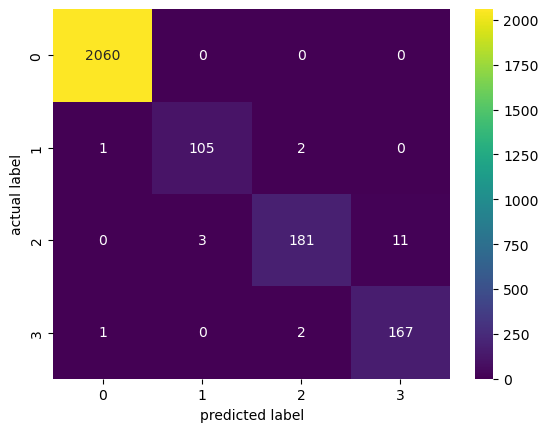

In [43]:
confusionmatrix = confusion_matrix(y_test,dt_pred)

sns.heatmap(confusionmatrix,annot=True,fmt='d',cmap='viridis')

plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.show()

## Hyperparameter Tuning using GridSearchCV:

In [44]:
from sklearn.model_selection import GridSearchCV

In [45]:
dt_clf.get_params().keys()

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [46]:
params = {
    'max_depth':[2,4,6,8,10],
    'min_samples_split':[10,20,30,40]   
}

In [47]:
gridsearch = GridSearchCV(dt_clf,param_grid=params,n_jobs=-1,cv=5)

gridsearch.fit(X_train_smt,y_train_smt)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'min_samples_split': [10, 20, 30, 40]})

In [48]:
gridsearch.best_params_

{'max_depth': 10, 'min_samples_split': 10}

In [49]:
dt_clf_best = DecisionTreeClassifier(max_depth= 10, min_samples_split= 30)

In [50]:
dt_clf_best.fit(X_train_smt,y_train_smt)

dt_best_pred = dt_clf_best.predict(X_test_norm)

The Accuracy of the model is 99.25%



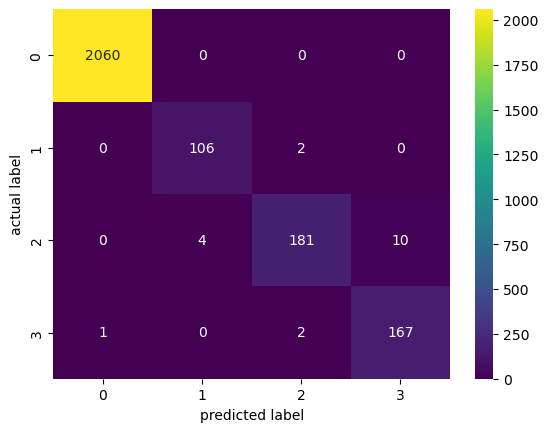

In [51]:
acc = accuracy_score(y_test,dt_best_pred)

print(f'The Accuracy of the model is {round(acc*100,2)}%\n')

confusionmatrix = confusion_matrix(y_test,dt_best_pred)

sns.heatmap(confusionmatrix,annot=True,fmt='d',cmap='viridis')

plt.ylabel('actual label')
plt.xlabel('predicted label')
plt.show()

# Using custom inputs to detect the Occupancy:

In [53]:
def detect_occupants(S1_Temp,S2_Temp,S1_Light,S4_Light,S5_CO2):
    '''Detects the occupancy of the room based on given inputs.'''
    
    var_list = [S1_Temp,S2_Temp,S1_Light,S4_Light,S5_CO2]
    vector_list = np.array(var_list).reshape(1,-1)
    norm_list = norm.transform(vector_list)
    
    occuapncy = dt_clf_best.predict(norm_list)
    
    return print(f'The Estimated Occupancy of the room is {occuapncy}.')

In [54]:
detect_occupants(25.81,28.87,160,67,675)

The Estimated Occupancy of the room is [3].
